# Vector Stores and Retrievals for RAG

RAG PDF Dataset: https://github.com/laxmimerit/rag-dataset

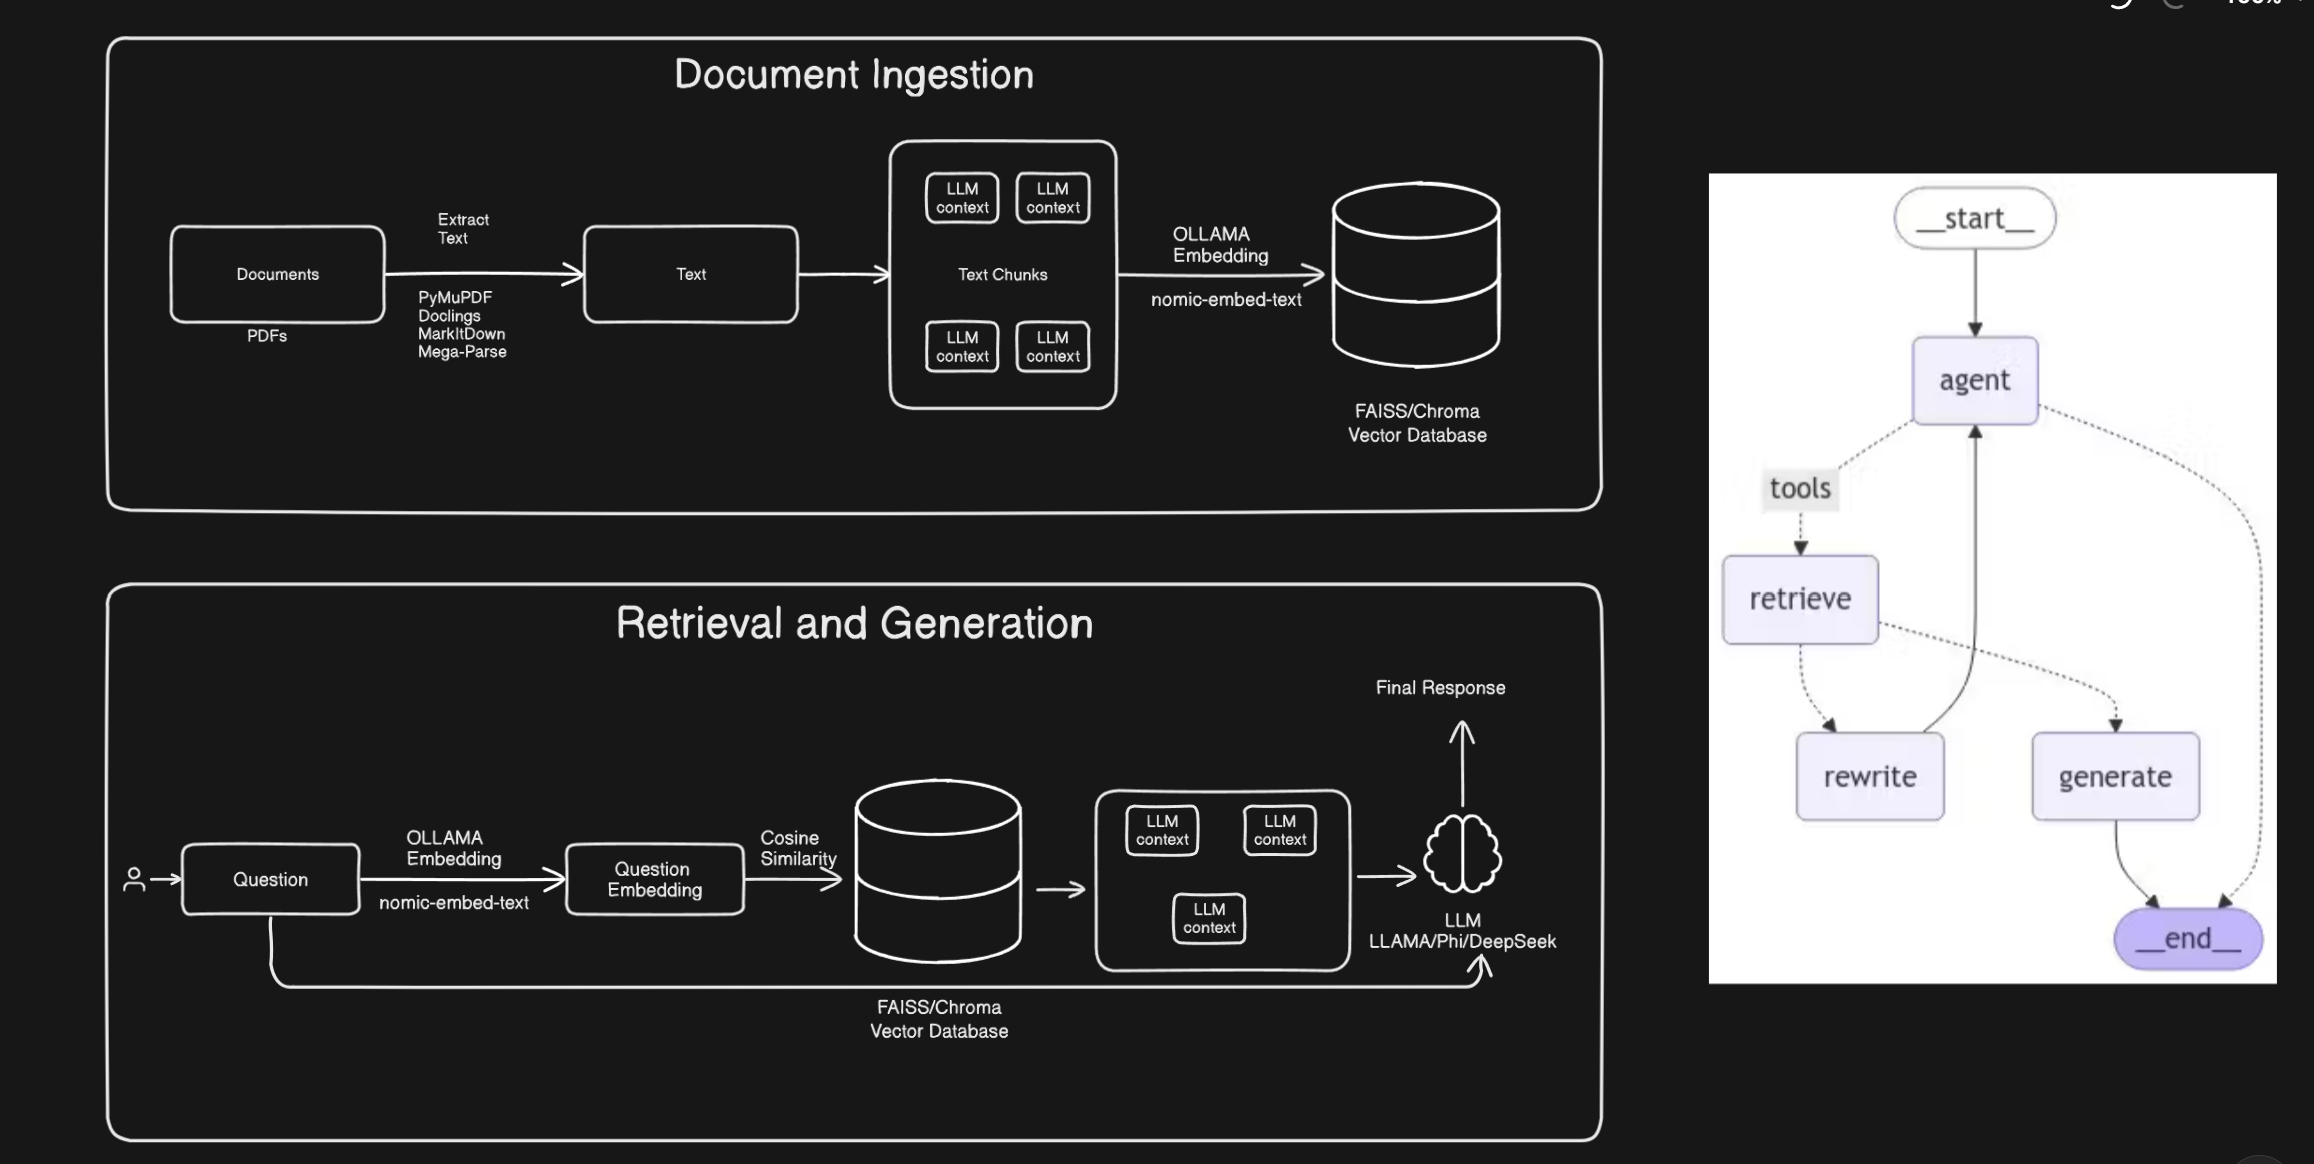

In [1]:
# pip install faiss-cpu

In [2]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv('../.env')

True

### Read Entire Directory
- Read all markdown files from the directory

In [3]:
import os

def read_markdown_files(input_dir):
    company_files = []

    for root, dirs, files in os.walk(input_dir):
        # Get the company name from the folder structure
        relative_path = os.path.relpath(root, input_dir)
        company_name = os.path.basename(relative_path)

        for file in files:
            if file.endswith(".md"):
                file_path = os.path.join(root, file)
                company_files.append({"company": company_name, "file_path": file_path})
    return company_files

# Example usage:
input_directory = "../00 Dataset/markdown"
md_files_with_companies = read_markdown_files(input_directory)

# Display results
for file in md_files_with_companies:
    print(file)
    


{'company': '.', 'file_path': '../00 Dataset/markdown\\llm_paper.md'}
{'company': 'amazon', 'file_path': '../00 Dataset/markdown\\amazon\\amazon-10-q-q3-2024.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\Downloadable-BS-Q3-24.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\Downloadable-PL-Q3-24.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\Earnings-Presentation-Q3-2024.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\Meta-09-30-2024-Exhibit-99-1_FINAL.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\META-Q3-2024-Earnings-Call-Transcript.md'}
{'company': 'facebook', 'file_path': '../00 Dataset/markdown\\facebook\\META-Q3-2024-Follow-Up-Call-Transcript.md'}
{'company': 'google', 'file_path': '../00 Dataset/markdown\\google\\goog-10-q-q3-2024.md'}


### Document Loader

In [4]:
from langchain_text_splitters import MarkdownHeaderTextSplitter, MarkdownTextSplitter


def get_markdown_splits(md_filename):
    with open(md_filename, "r", encoding="utf-8") as f:
        markdown_content = f.read()

    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)
    md_header_splits = markdown_splitter.split_text(markdown_content)

    return md_header_splits

md_filename = r"..\00 Dataset\markdown\amazon\amazon-10-q-q3-2024.md"
md_header_splits = get_markdown_splits(md_filename)

In [5]:
input_directory = "../00 Dataset/markdown"
md_files_with_companies = read_markdown_files(input_directory)
# md_files_with_companies

In [6]:
documents_with_metadata = []
for file_info in md_files_with_companies:
    company_name = file_info["company"]
    file_path = file_info["file_path"]

    md_header_splits = get_markdown_splits(file_path)

    # Add company name to metadata for each split
    for doc in md_header_splits:
        doc.metadata["company"] = company_name

    documents_with_metadata.extend(md_header_splits)


In [7]:
# documents_with_metadata

### Document Vector Embedding

In [8]:
from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS 
from langchain_community.docstore.in_memory import InMemoryDocstore

In [9]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url='http://localhost:11434')
vector = embeddings.embed_query("Hello World")
len(vector)
index = faiss.IndexFlatL2(len(vector))
index.ntotal, index.d

(0, 768)

In [12]:
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
vector_store.index.ntotal, vector_store.index.d
ids = vector_store.add_documents(documents=documents_with_metadata)

len(ids), vector_store.index.ntotal

In [24]:
### Retrieve documents
question = "What is the revenue of Amazon in 2024?"
docs = vector_store.search(query=question, k=3, search_type="similarity")

## Retrieve documents with Retriever
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})
docs = retriever.invoke(question, filter={"company": "amazon"})

In [25]:
# Store and Load the Vector Store

db_name = "earnings_2024"

vector_store.save_local(db_name)

In [ ]:
## Loading Vector Store

from langchain_ollama import OllamaEmbeddings

import faiss
from langchain_community.vectorstores import FAISS 
from langchain_community.docstore.in_memory import InMemoryDocstore


embeddings = OllamaEmbeddings(model='nomic-embed-text', base_url='http://localhost:11434')

db_name = "earnings_2024"
vector_store = FAISS.load_local(db_name, embeddings, allow_dangerous_deserialization=True)

## Retrieve documents with Retriever
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})
docs = retriever.invoke(question, filter={"company": "amazon"})